------------------------------------------------ 데이터 로딩 ------------------------------------------------ 

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import datetime

train = pd.read_csv('/Users/jaesolshin/내 드라이브/2024-2/Google ML Bootcamp2024/data/playground1/train.csv')

In [6]:
# 전체 데이터의 인덱스 생성
indices = np.arange(train.shape[0])

# 99:1 비율로 train, valid 분할
train_id, valid_id = train_test_split(indices, test_size=0.01, random_state=42)

# train에서 sample_t개, valid에서 sample_v개 샘플링
sample_t = 30000
sample_v = 1000
train_sample_id = np.random.choice(train_id, sample_t, replace=False)
valid_sample_id = np.random.choice(valid_id, sample_v, replace=False)

# train_x, train_y, valid_x, valid_y 생성
train_x = train.iloc[train_sample_id, :-1]
train_y = train.iloc[train_sample_id, -1]
valid_x = train.iloc[valid_sample_id, :-1]
valid_y = train.iloc[valid_sample_id, -1]

print("Train sample X shape:", train_x.shape)
print("Train sample Y shape:", train_y.shape)
print("Valid sample X shape:", valid_x.shape)
print("Valid sample Y shape:", valid_y.shape)

Train sample X shape: (30000, 11)
Train sample Y shape: (30000,)
Valid sample X shape: (1000, 11)
Valid sample Y shape: (1000,)


------------------------------------------------ 여기서부터 데이터 확인 및 전처리 ------------------------------------------------

In [25]:
train_x.head()
train_x.describe(include='all')
train_x['Driving_License'].value_counts() #면허 미소지자도 드물게 존재
train_y.value_counts()

KeyError: 'Driving_License'

In [8]:
# 범주형 변수들만 따로 확인
train_x.iloc[:10,[1,3,4,5,6,7,9]] 

# 범주형 변수를 팩터로 변환 (카테고리형)
train_x.iloc[:,[1,3,4,5,6,7,9]].apply(lambda x: x.astype('category'))
valid_x.iloc[:,[1,3,4,5,6,7,9]].apply(lambda x: x.astype('category'))

# 결측치 파악
print(train_x.isnull().sum()) #결측 없음
print(valid_x.isnull().sum()) #결측 없음

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64


Age                  0
Annual_Premium    6156
Vintage              0
dtype: int64


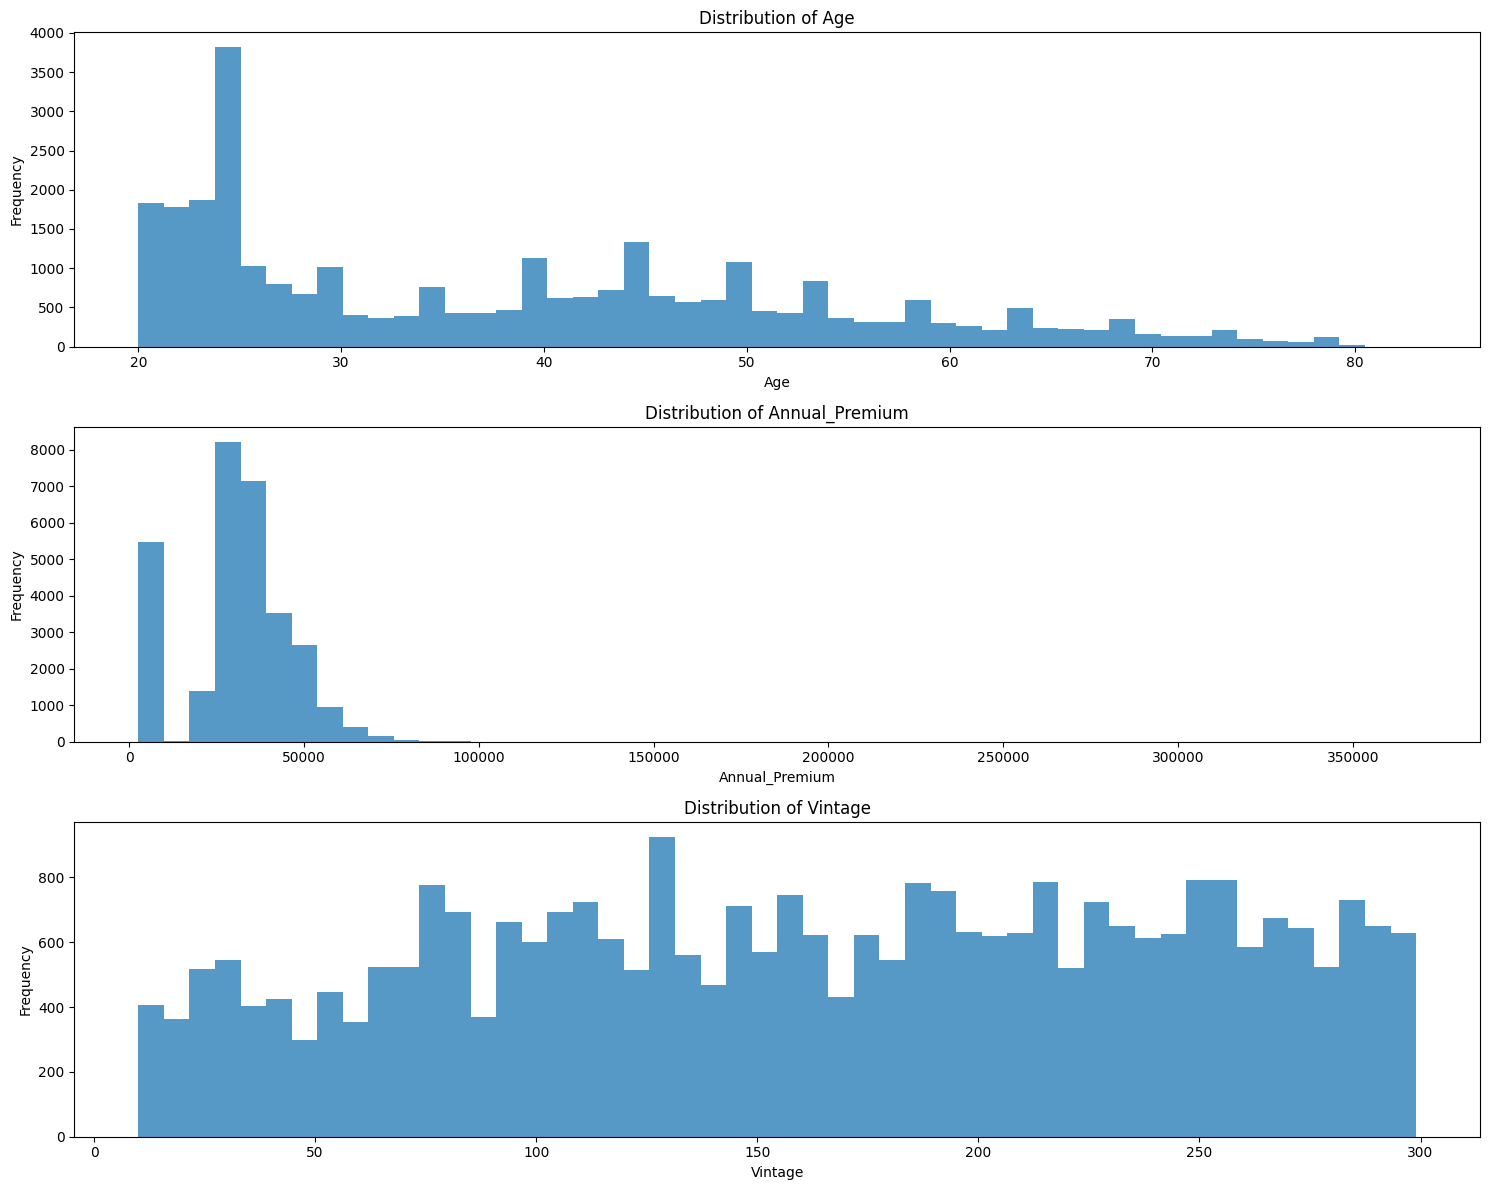

In [9]:
# 연속형 변수만 선택
train_x.iloc[:10,[2,8,10]]

# IQR 기반 이상치 탐지 함수
def outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

# 연속형 변수들에 대해 이상치 수 계산
print(outliers(train_x.iloc[:,[2,8,10]]).sum())

#연속형 변수들 시각화
fig, axes = plt.subplots(nrows=3, figsize=(15, 12))
axes = axes.flatten()

# 각 변수의 히스토그램 그리기
for ax, column in zip(axes, train_x.iloc[:,[2,8,10]]):
    ax.hist(train_x[column], bins=50, alpha=0.75)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")


plt.tight_layout()
plt.show()

#Annual_Premium 변수의 min값이 정규분포에서 크게 튀어보이는 것을 확인할 수 있음


In [10]:
#튀어보이는 수치는 0이 아닌 2630.0
print(train_x["Annual_Premium"].min())
print(train_x["Annual_Premium"].min())

#이상치로 판단된 값 또한 대부분 2630.0
train_x.loc[outliers(train_x["Annual_Premium"]),"Annual_Premium"].value_counts()

# 이분변수 생성: "Annual_Premium" == 2630.0 인 경우
train_x['Annual_Premium_Binary'] = (train_x['Annual_Premium'] == 2630.0).astype('category')
valid_x['Annual_Premium_Binary'] = (valid_x['Annual_Premium'] == 2630.0).astype('category')

# 로그 변환된 "Annual_Premium" 변수 생성
train_x['Annual_Premium_Log'] = np.log1p(train_x['Annual_Premium'])
valid_x['Annual_Premium_Log'] = np.log1p(valid_x['Annual_Premium'])

#생성된 변수 확인
train_x.head()

2630.0
2630.0


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Annual_Premium_Binary,Annual_Premium_Log
4155844,4155844,Male,48,1,8.0,1,1-2 Year,No,38221.0,26.0,246,False,10.551167
1024074,1024074,Male,47,1,28.0,0,1-2 Year,Yes,54727.0,26.0,144,False,10.910131
2428439,2428439,Male,25,1,41.0,1,< 1 Year,No,30512.0,152.0,235,False,10.325908
5650509,5650509,Female,22,1,8.0,1,< 1 Year,Yes,32157.0,152.0,272,False,10.378417
7333212,7333212,Female,49,1,28.0,0,1-2 Year,Yes,43854.0,26.0,220,False,10.688644


In [11]:
# 정규화
# StandardScaler, MinMaxScaler, RobustScaler 중에서 선택
from sklearn.preprocessing import StandardScaler

# 최소-최대 정규화 (Min-Max 스케일링)
scaler = StandardScaler()
train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
valid_x.iloc[:,[2,8,10]] = scaler.fit_transform(valid_x.iloc[:,[2,8,10]])

train_x.head()

/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_46756/4270348271.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.64232527  0.57573178 -0.88932495 ...  1.10847968  0.30935783
 -1.22229239]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_46756/4270348271.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.02109971 -0.24973579  0.88404883 ... -0.57367425 -0.23727662
 -1.44581626]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_46756/4270348271.py:8: FutureWarning: Setting an item o

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Annual_Premium_Binary,Annual_Premium_Log
4155844,4155844,Male,0.642325,1,8.0,1,1-2 Year,No,0.473010,26.0,1.021100,False,10.551167
1024074,1024074,Male,0.575732,1,28.0,0,1-2 Year,Yes,1.488244,26.0,-0.249736,False,10.910131
2428439,2428439,Male,-0.889325,1,41.0,1,< 1 Year,No,-0.001147,152.0,0.884049,False,10.325908
5650509,5650509,Female,-1.089105,1,8.0,1,< 1 Year,Yes,0.100032,152.0,1.345038,False,10.378417
7333212,7333212,Female,0.708919,1,28.0,0,1-2 Year,Yes,0.819479,26.0,0.697161,False,10.688644


In [12]:
# 예측에 필요 없는 'id'와 'Annual_Premium' 변수를 드롭
train_x = train_x.drop(columns=['id', 'Annual_Premium'])
valid_x = valid_x.drop(columns=['id', 'Annual_Premium'])

# 원-핫 인코딩 (One-Hot Encoding)
train_x = pd.get_dummies(train_x, columns=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Annual_Premium_Binary'])
valid_x = pd.get_dummies(valid_x, columns=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Annual_Premium_Binary'])

# train_x와 valid_x가 동일한 열을 가지도록 조정
train_x, valid_x = train_x.align(valid_x, join='left', axis=1, fill_value=0)

#생성된 변수 확인
train_x.head()

,Age,Vintage,Annual_Premium_Log,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Region_Code_0.0,Region_Code_1.0,Region_Code_2.0,...,Policy_Sales_Channel_154.0,Policy_Sales_Channel_155.0,Policy_Sales_Channel_156.0,Policy_Sales_Channel_157.0,Policy_Sales_Channel_158.0,Policy_Sales_Channel_159.0,Policy_Sales_Channel_160.0,Policy_Sales_Channel_163.0,Annual_Premium_Binary_False,Annual_Premium_Binary_True
4155844,0.642325,1.021100,10.551167,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1024074,0.575732,-0.249736,10.910131,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2428439,-0.889325,0.884049,10.325908,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
5650509,-1.089105,1.345038,10.378417,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7333212,0.708919,0.697161,10.688644,True,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False


------------------------------------------------ 이제 드디어 모델링 ------------------------------------------------

In [13]:
#평가를 위한 패키지 임포트
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [14]:
from sklearn.linear_model import LogisticRegression

# 시작 시간 기록
start_time = time.time()

# 로지스틱 회귀 모델 생성 및 학습
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred = logistic_model.predict(valid_x)

# 성능 평가
accuracy = accuracy_score(valid_y, valid_y_pred)
conf_matrix = confusion_matrix(valid_y, valid_y_pred)
class_report = classification_report(valid_y, valid_y_pred)

# 결과 출력
print(accuracy)
print(conf_matrix)
print(class_report)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.87
[[868   2]
 [128   2]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       870
           1       0.50      0.02      0.03       130

    accuracy                           0.87      1000
   macro avg       0.69      0.51      0.48      1000
weighted avg       0.82      0.87      0.81      1000

실행 시간: 2.116424초


In [15]:
'''
from sklearn.svm import SVC

# 시작 시간 기록
start_time = time.time()

# SVM 모델 생성 및 학습
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_svm = svm_model.predict(valid_x)

# 성능 평가
accuracy_svm1 = accuracy_score(valid_y, valid_y_pred_svm)
conf_matrix_svm1 = confusion_matrix(valid_y, valid_y_pred_svm)
class_report_svm1 = classification_report(valid_y, valid_y_pred_svm)

# 결과 출력
print(accuracy_svm1)
print(conf_matrix_svm1)
print(class_report_svm1)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)
'''

'\nfrom sklearn.svm import SVC\n\n# 시작 시간 기록\nstart_time = time.time()\n\n# SVM 모델 생성 및 학습\nsvm_model = SVC(kernel=\'linear\', random_state=42)\nsvm_model.fit(train_x, train_y)\n\n# 검증 데이터에 대해 예측\nvalid_y_pred_svm = svm_model.predict(valid_x)\n\n# 성능 평가\naccuracy_svm1 = accuracy_score(valid_y, valid_y_pred_svm)\nconf_matrix_svm1 = confusion_matrix(valid_y, valid_y_pred_svm)\nclass_report_svm1 = classification_report(valid_y, valid_y_pred_svm)\n\n# 결과 출력\nprint(accuracy_svm1)\nprint(conf_matrix_svm1)\nprint(class_report_svm1)\n\n# 종료 시간 기록\nend_time = time.time()\nexecution_time = end_time - start_time\nprint("실행 시간: %f초" %execution_time)\n'

In [16]:
'''
# 시작 시간 기록
start_time = time.time()

# SVM 모델 생성 및 학습
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_svm = svm_model.predict(valid_x)

# 성능 평가
accuracy_svm2 = accuracy_score(valid_y, valid_y_pred_svm)
conf_matrix_svm2 = confusion_matrix(valid_y, valid_y_pred_svm)
class_report_svm2 = classification_report(valid_y, valid_y_pred_svm)

# 결과 출력
print(accuracy_svm2)
print(conf_matrix_svm2)
print(class_report_svm2)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)
'''

'\n# 시작 시간 기록\nstart_time = time.time()\n\n# SVM 모델 생성 및 학습\nsvm_model = SVC(kernel=\'rbf\', random_state=42)\nsvm_model.fit(train_x, train_y)\n\n# 검증 데이터에 대해 예측\nvalid_y_pred_svm = svm_model.predict(valid_x)\n\n# 성능 평가\naccuracy_svm2 = accuracy_score(valid_y, valid_y_pred_svm)\nconf_matrix_svm2 = confusion_matrix(valid_y, valid_y_pred_svm)\nclass_report_svm2 = classification_report(valid_y, valid_y_pred_svm)\n\n# 결과 출력\nprint(accuracy_svm2)\nprint(conf_matrix_svm2)\nprint(class_report_svm2)\n\n# 종료 시간 기록\nend_time = time.time()\nexecution_time = end_time - start_time\nprint("실행 시간: %f초" %execution_time)\n'

In [17]:
from sklearn.ensemble import RandomForestClassifier

# 시작 시간 기록
start_time = time.time()

# Random Forest 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_rf = rf_model.predict(valid_x)

# 성능 평가
accuracy_rf = accuracy_score(valid_y, valid_y_pred_rf)
conf_matrix_rf = confusion_matrix(valid_y, valid_y_pred_rf)
class_report_rf = classification_report(valid_y, valid_y_pred_rf)

# 결과 출력
print(accuracy_rf)
print(conf_matrix_rf)
print(class_report_rf)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.857
[[845  25]
 [118  12]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       870
           1       0.32      0.09      0.14       130

    accuracy                           0.86      1000
   macro avg       0.60      0.53      0.53      1000
weighted avg       0.81      0.86      0.82      1000

실행 시간: 7.179087초


In [18]:
from catboost import CatBoostClassifier

# 시작 시간 기록
start_time = time.time()

# CatBoost 모델 생성 및 학습
catboost_model = CatBoostClassifier(iterations=100, random_seed=42, silent=True)
catboost_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_catboost = catboost_model.predict(valid_x)

# 성능 평가
accuracy_cat = accuracy_score(valid_y, valid_y_pred_catboost)
conf_matrix_cat = confusion_matrix(valid_y, valid_y_pred_catboost)
class_report_cat = classification_report(valid_y, valid_y_pred_catboost)

# 결과 출력
print(accuracy_cat)
print(conf_matrix_cat)
print(class_report_cat)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.867
[[864   6]
 [127   3]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       870
           1       0.33      0.02      0.04       130

    accuracy                           0.87      1000
   macro avg       0.60      0.51      0.49      1000
weighted avg       0.80      0.87      0.81      1000

실행 시간: 1.781460초


In [19]:
from lightgbm import LGBMClassifier

# 시작 시간 기록
start_time = time.time()

# LightGBM 모델 생성 및 학습
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_lgbm = lgbm_model.predict(valid_x)

# 성능 평가
accuracy_lgbm = accuracy_score(valid_y, valid_y_pred_lgbm)
conf_matrix_lgbm = confusion_matrix(valid_y, valid_y_pred_lgbm)
class_report_lgbm = classification_report(valid_y, valid_y_pred_lgbm)

# 결과 출력
print(accuracy_lgbm)
print(conf_matrix_lgbm)
print(class_report_lgbm)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3654, number of negative: 26346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121800 -> initscore=-1.975494
[LightGBM] [Info] Start training from score -1.975494
0.867
[[862   8]
 [125   5]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       870
           1       0.38      0.04      0.07       130

    accuracy                           0.87      1000
   macro avg       0.63      0.51      0.50      1000
weighted avg       0.81      0.87      0.82      1000

실행 시간: 

In [20]:
from xgboost import XGBClassifier

train_x.columns = train_x.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')
valid_x.columns = valid_x.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')

# 시작 시간 기록
start_time = time.time()

# XGBoost 모델 생성 및 학습
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(train_x, train_y)

# 검증 데이터에 대해 예측
valid_y_pred_xgb = xgb_model.predict(valid_x)

# 성능 평가
accuracy_xgb = accuracy_score(valid_y, valid_y_pred_xgb)
conf_matrix_xgb = confusion_matrix(valid_y, valid_y_pred_xgb)
class_report_xgb = classification_report(valid_y, valid_y_pred_xgb)

# 결과 출력
print(accuracy_xgb)
print(conf_matrix_xgb)
print(class_report_xgb)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time
print("실행 시간: %f초" %execution_time)

0.868
[[859  11]
 [121   9]]
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       870
           1       0.45      0.07      0.12       130

    accuracy                           0.87      1000
   macro avg       0.66      0.53      0.52      1000
weighted avg       0.82      0.87      0.82      1000

실행 시간: 1.892512초


In [21]:
# 시작 시간 기록
start_time = time.time()

# 평가 지표 계산 함수
def evaluate_model(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # 혼동 행렬로부터 계산
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return {
        'Confusion Matrix': conf_matrix.tolist(),
        'Accuracy': accuracy,
        'Precision': precision,
        'Positive Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
    }

# 개별 모델 생성
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

# 결과를 저장할 리스트 초기화
results = []
probas = []

# 각 모델 학습 및 평가
for name, model in models:
    # 학습
    model.fit(train_x, train_y)
    
    # 예측
    valid_y_pred = model.predict(valid_x)
    valid_y_proba = model.predict_proba(valid_x)[:, 1]  # 양성 클래스의 확률만 저장
    
    # 평가
    metrics = evaluate_model(valid_y, valid_y_pred)
    metrics.update({
        'Model': name,
        'y_true': valid_y,
        'y_scores': valid_y_proba
    })
    
    results.append(metrics)
    probas.append(valid_y_proba)

# DataFrame 생성
results_df = pd.DataFrame(results)

# Precision과 Positive Recall 기반 가중치 계산
weights_precision = results_df['Precision'] / results_df['Precision'].sum()
weights_recall = results_df['Positive Recall'] / results_df['Positive Recall'].sum()
results_df['Weight (Precision)'] = weights_precision
results_df['Weight (Recall)'] = weights_recall

# Precision 기반 앙상블
weighted_probas_prec = np.average(probas, axis=0, weights=weights_precision)
valid_y_pred_ens_prec = (weighted_probas_prec >= 0.5).astype(int)

# Recall 기반 앙상블
weighted_probas_rec = np.average(probas, axis=0, weights=weights_recall)
valid_y_pred_ens_rec = (weighted_probas_rec >= 0.5).astype(int)

# 앙상블 모델들의 성능 평가
ensemble_results = []

for ens_name, valid_y_pred_ens, weighted_probas_ens in [("Ensemble (Precision)", valid_y_pred_ens_prec, weighted_probas_prec), 
                                                        ("Ensemble (Recall)", valid_y_pred_ens_rec, weighted_probas_rec)]:
    metrics_ens = evaluate_model(valid_y, valid_y_pred_ens)
    metrics_ens.update({
        'Model': ens_name,
        'Weight (Precision)': np.nan,
        'Weight (Recall)': np.nan,
        'y_true': valid_y,
        'y_scores': weighted_probas_ens
    })
    ensemble_results.append(metrics_ens)

# 결과 DataFrame에 앙상블 결과 추가
results_df = pd.concat([results_df, pd.DataFrame(ensemble_results)], ignore_index=True)

# 종료 시간 기록
end_time = time.time()
execution_time = end_time - start_time

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3654, number of negative: 26346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121800 -> initscore=-1.975494
[LightGBM] [Info] Start training from score -1.975494



Total execution time: 30.84 seconds

=== Model Results ===
      Confusion Matrix  Accuracy  Precision  Positive Recall  Specificity  F1-Score                Model  Weight (Precision)  Weight (Recall)      AUC
  [[868, 2], [128, 2]]     0.870   0.500000         0.015385     0.997701  0.029851  Logistic Regression            0.245828         0.064516 0.859107
[[845, 25], [118, 12]]     0.857   0.324324         0.092308     0.971264  0.143713        Random Forest            0.159456         0.387097 0.840270
  [[865, 5], [127, 3]]     0.868   0.375000         0.023077     0.994253  0.043478             CatBoost            0.184371         0.096774 0.856278
  [[862, 8], [125, 5]]     0.867   0.384615         0.038462     0.990805  0.069930             LightGBM            0.189099         0.161290 0.853550
 [[859, 11], [121, 9]]     0.868   0.450000         0.069231     0.987356  0.120000              XGBoost            0.221245         0.290323 0.843466
  [[868, 2], [128, 2]]     0.870  

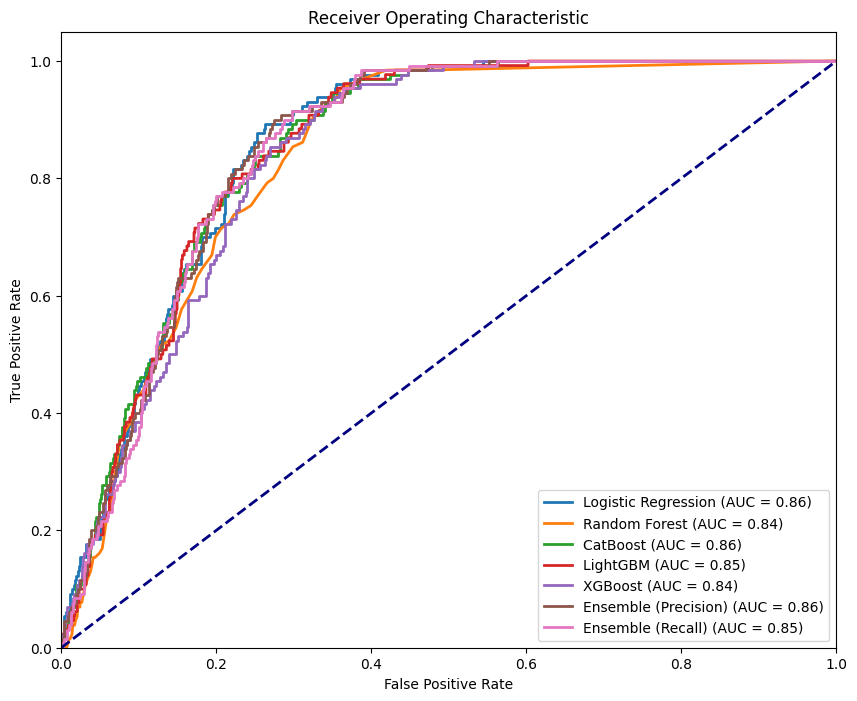

In [22]:
# AUC 값을 저장할 딕셔너리 초기화
auc_values = {}

# ROC 커브와 AUC 추가
plt.figure(figsize=(10, 8))

for index, row in results_df.iterrows():
    if pd.isna(row['y_true']).any() or pd.isna(row['y_scores']).any():
        continue  # y_true 또는 y_scores에 NaN이 있으면 건너뜀
    y_true = row['y_true']
    y_scores = row['y_scores']
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    auc_values[row['Model']] = roc_auc
    plt.plot(fpr, tpr, lw=2, label=f"{row['Model']} (AUC = {roc_auc:.2f})")

# AUC 값을 results_df에 추가
results_df['AUC'] = results_df['Model'].map(auc_values)

# 특정 열(y_true, y_scores) 제외하고 결과 출력
print(f"\nTotal execution time: {execution_time:.2f} seconds")
print("\n=== Model Results ===")
print(results_df.drop(columns=['y_true', 'y_scores']).to_string(index=False))

# 가장 성능이 좋은 모델 찾기 (Accuracy, Precision, Recall, Positive Recall, F1-Score, AUC 기준)
best_model_acc = results_df.loc[results_df['Accuracy'].idxmax()]
best_model_prec = results_df.loc[results_df['Precision'].idxmax()]
best_model_pos_rec = results_df.loc[results_df['Positive Recall'].idxmax()]
best_model_rec = results_df.loc[results_df['Specificity'].idxmax()]
best_model_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
best_model_auc = results_df.loc[results_df['AUC'].idxmax()]

print(f"\nBest performing model (based on Accuracy): {best_model_acc['Model']} with Accuracy {best_model_acc['Accuracy']:.4f}")
print(f"Best performing model (based on Precision): {best_model_prec['Model']} with Precision {best_model_prec['Precision']:.4f}")
print(f"Best performing model (based on Positive Recall): {best_model_pos_rec['Model']} with Positive Recall {best_model_pos_rec['Positive Recall']:.4f}")
print(f"Best performing model (based on F1-Score): {best_model_f1['Model']} with F1-Score {best_model_f1['F1-Score']:.4f}")
print(f"Best performing model (based on AUC): {best_model_auc['Model']} with AUC {best_model_auc['AUC']:.4f}")

# 앙상블 모델들 비교
ens_prec = results_df[results_df['Model'] == 'Ensemble (Precision)'].iloc[0]
ens_rec = results_df[results_df['Model'] == 'Ensemble (Recall)'].iloc[0]

print("\nEnsemble Models Comparison (based on F1-Score):")
print(f"Ensemble (Precision) - F1-Score: {ens_prec['F1-Score']:.4f}")
print(f"Ensemble (Recall) - F1-Score: {ens_rec['F1-Score']:.4f}")

if ens_prec['F1-Score'] > ens_rec['F1-Score']:
    print("Ensemble (Precision) has better overall F1-Score.")
elif ens_prec['F1-Score'] < ens_rec['F1-Score']:
    print("Ensemble (Recall) has better overall F1-Score.")
else:
    print("Both Ensembles have the same overall F1-Score.")

# ROC 커브 그리기
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [23]:
# 종료 시간 기록
full_end_time = time.time()
execution_time = full_end_time - full_start_time
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))
print("실행 시간: ", execution_time_formatted)

실행 시간:  0:00:54


In [24]:
results_df

,Confusion Matrix,Accuracy,Precision,Positive Recall,Specificity,F1-Score,Model,y_true,y_scores,Weight (Precision),Weight (Recall),AUC
0,"[[868, 2], [128, 2]]",0.870,0.500000,0.015385,0.997701,0.029851,Logistic Regression,8953777 0 519699 0 11162199 1 4460...,"[0.00031164062544094797, 0.0005379118639078423...",0.245828,0.064516,0.859107
1,"[[845, 25], [118, 12]]",0.857,0.324324,0.092308,0.971264,0.143713,Random Forest,8953777 0 519699 0 11162199 1 4460...,"[0.0, 0.0, 0.44, 0.31, 0.26, 0.42, 0.1, 0.02, ...",0.159456,0.387097,0.840270
2,"[[865, 5], [127, 3]]",0.868,0.375000,0.023077,0.994253,0.043478,CatBoost,8953777 0 519699 0 11162199 1 4460...,"[0.0002386450932421526, 0.00023386790778603465...",0.184371,0.096774,0.856278
3,"[[862, 8], [125, 5]]",0.867,0.384615,0.038462,0.990805,0.069930,LightGBM,8953777 0 519699 0 11162199 1 4460...,"[0.0002069859283136954, 0.00031770374450954035...",0.189099,0.161290,0.853550
4,"[[859, 11], [121, 9]]",0.868,0.450000,0.069231,0.987356,0.120000,XGBoost,8953777 0 519699 0 11162199 1 4460...,"[0.00017456646, 0.00013833004, 0.2891091, 0.23...",0.221245,0.290323,0.843466
5,"[[868, 2], [128, 2]]",0.870,0.500000,0.015385,0.997701,0.029851,Ensemble (Precision),8953777 0 519699 0 11162199 1 4460...,"[0.0001983722043170605, 0.00026603476057254847...",NaN,NaN,0.857171
6,"[[861, 9], [126, 4]]",0.865,0.307692,0.030769,0.989655,0.055944,Ensemble (Recall),8953777 0 519699 0 11162199 1 4460...,"[0.00012726594645457188, 0.0001487392431683097...",NaN,NaN,0.854553
